In [12]:

import matplotlib.pyplot as plt
from matplotlib.widgets import Cursor
import numpy as np

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()

from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Probe.Plot import plot
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *

from Transformer import Transformer

 ### <font color='teal'>Power Supply</font> 

In [13]:
circuit = Circuit('Regulated Power Supply Circuit')

circuit.model('1N4002', 'D', IS = 14.11E-11, N = 1.984, RS = 33.89E-3,
              IKF=94.81, XTITUN=3, KEG=1.110, CJO = 51.17E-12, M = .2762,
              VJ = .3905, FC = 0.5, ISR=100.0E-12, NR=2, BV=100.1, IBV=10,
              TT = 4.761E-6)

circuit.model('1N751', 'D', IS = 1.004E-15, N = 1, RS = .5875, IKF=0,
              XTITUN=3, EG=1.11, CJO = 160E-12, M = .5484, VJ = 0.75,
              FC = 0.5, ISR=1.8E-9, NR=2, BV=5.1, IBV=27.721E-3, NBV=1.1779)

source = circuit.SinusoidalVoltageSource(1, 'pri', circuit.gnd, amplitude=339.41@u_V, frequency=70@u_Hz)

turn_ratio = 20
circuit.subcircuit(Transformer(turn_ratio))
circuit.X('transformer', 'Transformer', 'pri', circuit.gnd, 'sec_plus', 'sec_minus')

circuit.D('D1',   'sec_plus',  'smooth'    ,  model='1N4002')
circuit.D('D2',   circuit.gnd, 'sec_plus'  ,  model='1N4002')
circuit.D('D3',   circuit.gnd, 'sec_minus' ,  model='1N4002')
circuit.D('D4',   'sec_minus', 'smooth'    ,  model='1N4002')
circuit.R('load', 'output',     circuit.gnd,  10@u_kΩ  )
circuit.C('C1',   'smooth',     circuit.gnd,  1@u_mF    )
circuit.R('R1',   'smooth',    'output'    ,  100@u_Ω   )
circuit.D('Z1',   'output', circuit.gnd    ,  model='1N751')

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.transient(step_time=1@u_us, end_time=80@u_ms)

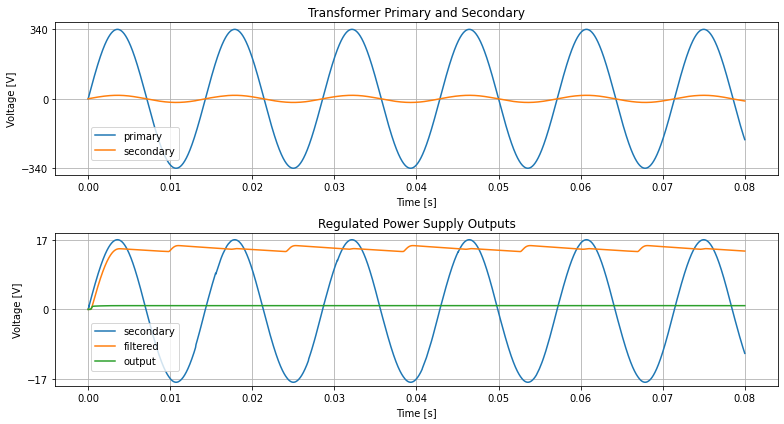

In [14]:
figure = plt.subplots(figsize=(11, 6))

axe = plt.subplot(211)
plt.title('Transformer Primary and Secondary')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.grid()
plot(analysis['pri'], axis=axe)
plot(analysis.sec_plus - analysis.sec_minus, axis=axe)
plt.legend(('primary', 'secondary'), loc=(.05,.1))
plt.ylim(float(-source.amplitude*1.1), float(source.amplitude*1.1))
axe.set_yticks([-340, 0, 340])
plt.tight_layout()

axe = plt.subplot(212)
plt.title('Regulated Power Supply Outputs')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.grid()
plot(analysis.sec_plus - analysis.sec_minus, axis=axe)
plot(analysis['smooth'], axis=axe)
plot(analysis['output'], axis=axe)
plt.legend(('secondary', 'filtered', 'output'), loc=(.05,.1))
plt.ylim(float(-source.amplitude*1.1/turn_ratio), float(source.amplitude*1.1/turn_ratio))
axe.set_yticks([-17, 0, 17])
cursor = Cursor(axe, useblit=True, color='red', linewidth=1)
plt.tight_layout()
plt.show()

In [ ]:
circuit = Circuit('Regulated Power Supply Circuit')
circuit.include("1N4002.lib")
circuit.include("1N751.lib")


source = circuit.SinusoidalVoltageSource(1, 'pri', circuit.gnd, amplitude=339.41@u_V, frequency=50@u_Hz)

turn_ratio = 20
circuit.subcircuit(Transformer(turn_ratio))
circuit.X('transformer', 'Transformer', 'pri', circuit.gnd, 'sec_plus', 'sec_minus')

circuit.X('D1', '1N4002', 'sec_plus', 'smooth')
circuit.X('D2', '1N4002', circuit.gnd, 'sec_plus')
circuit.X('D3', '1N4002', circuit.gnd, 'sec_minus')
circuit.X('D4', '1N4002', 'sec_minus', 'smooth')
circuit.C('1', 'smooth', circuit.gnd, 1@u_mF)
circuit.R('Rs', 'smooth', 'output', 100@u_Ω)
circuit.X('Z', '1N751', circuit.gnd, 'output')
circuit.R('load', 'output', circuit.gnd, 1@u_kΩ)

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.transient(step_time=1@u_us, end_time=60@u_ms)